## Plan

1. read words from data file.
2. preprocess and clean words.

See `Part2_readme.md` for information about this data.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# set the font size of plots
plt.rcParams['font.size'] = 14

np.set_printoptions(precision=3)

In [5]:
from nltk import FreqDist
import re

In [6]:
# Add higher directory to python modules path.

import sys
sys.path.append("..")

In [7]:
from utilities import arabic_nlp_utils, generic_nlp_utils

## Load Data

In [8]:
words_corpus_df = pd.read_csv('../../raw_data/OSAc-wordlist-frequency.csv')
words_corpus_df.shape

(432061, 2)

In [340]:
words_corpus_df.columns

Index(['الكلمة', 'التكرار'], dtype='object')

In [341]:
words_corpus_df.columns = ['word','frequency']

In [342]:
words_corpus_df.head()

,word,frequency
0,في,455629
1,من,413515
2,على,212554
3,أن,166261
4,إلى,121932


In [343]:
words_corpus_df.tail()

,word,frequency
432056,?جعل,1
432057,?ختاروا,1
432058,?سعون,1
432059,?عتقدون,1
432060,?کون,1


In [431]:
L = ['ياريت','يزي','يطيح','باش','بالقوي','بابا','ايه','وش','انتي','وهوما','يجي','وه','يكونو','انو','ايا','ياسي','ياسر','وياسر','ولات']
L = ['الحبس','ياريت','يزي','يطيح','باش','بالقوي','بابا','ايه','وش'
     ,'انتي','وهوما','يجي','وه','يكونو','انو','ايا','ياسي','ياسر','وياسر','ولات','الحجامة', 'الخمج','الجاية', 'اكا']
idx = words_corpus_df.word.isin(L)
words_corpus_df[idx]

,word,frequency
2695,وه,862
5034,بابا,420
5816,ياسر,350
13070,وش,133
20228,ايه,77
40209,وياسر,31


### Quick adhoc corpus cleanup
- remove infrequent words (occur in less than 30 words of the corpus)
- Remove words that start with 'ء'
- remove duplicate words (if any)

In [344]:
words_corpus_df = words_corpus_df[words_corpus_df.frequency>=30]
words_corpus_df.shape

(41200, 2)

In [345]:
## Remove words that start with 'ء'

idx = words_corpus_df.word.str.startswith('ء')
print(idx.sum())
print(words_corpus_df.loc[idx,'word'].tolist())
words_corpus_df = words_corpus_df[~idx]
words_corpus_df.shape

0
[]


(41200, 2)

In [346]:
# Remove duplicate words

if words_corpus_df.word.nunique()!=words_corpus_df.shape[0]:
    words_corpus_df = words_corpus_df.groupby('word').agg(sum).reset_index()

In [347]:
words_corpus_df.shape

(41200, 2)

****

## Explore Corpus Character Set

- This analysis can be performed either using `nltk.FreqDist` or ...

In [348]:
corpus_as_char_list = "".join(words_corpus_df.word.tolist())
print(type(corpus_as_char_list),len(corpus_as_char_list))

<class 'str'> 231204


In [349]:
fdist1 = FreqDist([c for c in corpus_as_char_list])

In [350]:
print("number of characters:" + str(fdist1.N()))
print("number of unique characters:" + str(fdist1.B()))

number of characters:231204
number of unique characters:40


In [351]:
print('List of distinct characters:')
print(sorted(list(fdist1.keys())))

List of distinct characters:
['?', 'C', 'N', 'ء', 'آ', 'أ', 'ؤ', 'إ', 'ئ', 'ا', 'ب', 'ة', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ـ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ى', 'ي']


In [352]:
print('The most common characters:')
fdist1.most_common(5)

The most common characters:


[('ا', 35819), ('ل', 24836), ('ي', 15534), ('و', 14355), ('ت', 13169)]

In [353]:
# ?fdist1.plot

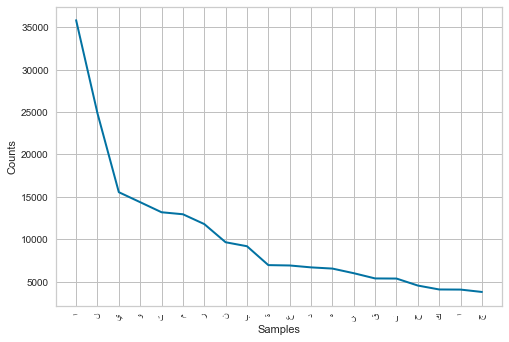

In [354]:
fdist1.plot(20, cumulative=False)

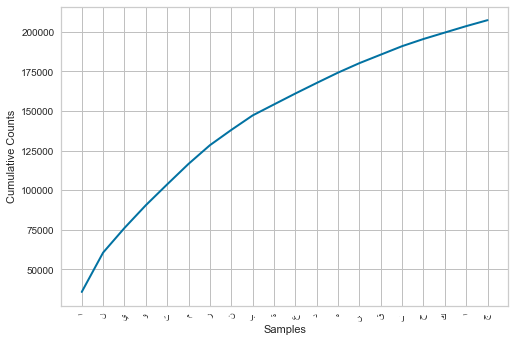

In [355]:
fdist1.plot(20,cumulative=True)

In [356]:
corpus_chars_df = pd.DataFrame(fdist1.items())
corpus_chars_df.columns = ['character','frequency']

# Unicode number of each distinct character:
corpus_chars_df['unicode_dec']= corpus_chars_df.character.map(ord)
corpus_chars_df['unicode_hex']= corpus_chars_df.character.map(lambda x: hex(ord(x)))

corpus_chars_df = corpus_chars_df.set_index('character')

corpus_chars_df.head()

,frequency,unicode_dec,unicode_hex
character,,,
ف,5351,1601,0x641
ي,15534,1610,0x64a
م,12932,1605,0x645
ن,9631,1606,0x646
ع,6893,1593,0x639


In [357]:
# Rare characters

u = corpus_chars_df[corpus_chars_df.frequency<10]
print(u.shape[0])
#print(sorted(u.index.tolist()))
print(','.join(sorted(u.index.tolist())))

3
?,C,N


In [358]:
# Rare characters sorted by unicode value

u.sort_values(by='unicode_dec', ascending=False).head(10)

,frequency,unicode_dec,unicode_hex
character,,,
N,2,78,0x4e
C,1,67,0x43
?,4,63,0x3f


*Observations & conclusions*

- 83 distinct characters, with 40 characters being rare characters (occur less than 10 times)
- The top 20 characters cover more than 95% of all character occurrences in the corpus
- Type of characters:

      40 English alphabet letters (A-Z)
      
      'A', 'B', 'C', 'D', 'F', 'H', 'I', 'L', 'M', 'N', 'O', 'P', 'Q', 'S', 'T', 'U', 'V', 'X', 'Y', 'a', 'b', 'c', 'd', 'e', 'g', 'h', 'i', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'y', 'z'

      42 Arabic letters:

      'ء', 'آ', 'أ', 'ؤ', 'إ', 'ئ', 'ا', 'ب', 'ة', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ـ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ى', 'ي', 'پ', 'چ', 'ک', 'گ', 'ھ', 'ہ'


      1 Non-letter character: ?


- 46 characters that should be removed because non-Arabic letters or occur rarely (less than 10 times):

       'پ', 'چ', 'ک', 'گ', 'ھ', 'ہ'
       '?'
       all English letters

- Characters that require special normalization/preprocessing (such as special encoded characters):

      'ـ'
      'ء', 'آ', 'أ', 'ؤ', 'إ', 'ئ', 'ا'
      'ى', 'ي'


### Identify Unwanted Characters

- Rare/uncommon Arabic letters:  'پ', 'چ', 'ک', 'گ', 'ھ', 'ہ'
- useless characters: 'ـ'  (*tatweel*)
- non-Arabic characters: '?', all English letters

In [359]:
corpus_chars_df.head()

,frequency,unicode_dec,unicode_hex
character,,,
ف,5351,1601,0x641
ي,15534,1610,0x64a
م,12932,1605,0x645
ن,9631,1606,0x646
ع,6893,1593,0x639


In [360]:
idx1 = pd.Series(corpus_chars_df.index.map(lambda x: re.match('[a-zA-Z?]',x)==None),index=corpus_chars_df.index)
idx2 = (corpus_chars_df.frequency>=10)
idx1.sum(), idx2.sum(), (idx1&idx2).sum()

(37, 37, 37)

In [361]:
corpus_chars_df_not_AR = corpus_chars_df.loc[~(idx1&idx2)]
corpus_chars_df_not_AR.shape

(3, 3)

In [362]:
unwanted_characters = sorted(corpus_chars_df_not_AR.index.tolist())
print(len(unwanted_characters))

3


In [363]:
#corpus_chars_df_not_AR

In [364]:
corpus_chars_df_AR = corpus_chars_df.loc[idx1&idx2]
corpus_chars_df_AR.shape

(37, 3)

In [365]:
#corpus_chars_df_AR.sort_values(by='frequency')

******

## Corpus cleanup based on simple linguistic rules and heuristics
- remove words that contain non-Arabic letters
- Arabic letter normalization (remove tatweel and diacritics; for now do **not** conflate hamzas and alifs)
- remove elongated words (informal/social media non-standard spelling)
- remove one-letter words
- remove very long words

### Remove Words that Contain Unwanted Characters

In [366]:
words_corpus_df.shape

(41200, 2)

In [367]:
words_corpus_df.head()

,word,frequency
0,في,455629
1,من,413515
2,على,212554
3,أن,166261
4,إلى,121932


In [368]:
unwanted_characters_regexp = '[' + ''.join(unwanted_characters) + ']'
unwanted_characters_regexp

'[?CN]'

In [369]:
idx = words_corpus_df.word.map(lambda x: re.search(unwanted_characters_regexp,x)!=None)
idx.sum()

4

In [370]:
# Just for checking ...

#idx2 = words_corpus_df.word.map(lambda x: re.search(arabic_nlp_utils.NON_ARABIC_CHARS_REGEX,x)!=None)
#idx2.sum()

#S1 = set(words_corpus_df.loc[idx,'word'].tolist())
#S2 = set(words_corpus_df.loc[idx2,'word'].tolist())

#np.sum(idx2),len(S2)

#len(S1),len(S2),len(S1&S2),len(S1-S2),len(S2-S1)

In [371]:
words_corpus_df.loc[idx].word.tolist()

['?ي', 'لـCNN', '?ان', 'بي?اس?']

In [372]:
words_corpus_df_clean = words_corpus_df.loc[~idx]

In [373]:
words_corpus_df_clean.shape

(41196, 2)

In [374]:
words_corpus_df_clean.head()

,word,frequency
0,في,455629
1,من,413515
2,على,212554
3,أن,166261
4,إلى,121932


In [375]:
assert(words_corpus_df_clean.shape[0]==words_corpus_df_clean.word.nunique())

### Arabic Letter Normalization

1. remove tatweel and diacritics
2. orthographic letter noramlization (letters written in different ways, such as alif and hamza) -- NOT USED FOR THIS CORPUS FOR NOW UNTIL FURTHER ANALYSIS ...

See documentation of function `arabic_nlp_utils.normalize_arabic_text` for more details.

In [376]:
## 1) remove tatweel and diacritics
words_corpus_df_clean['word_norm'] = words_corpus_df_clean.word.map(lambda w: arabic_nlp_utils.normalize_arabic_text_1(w))

## 2) orthographic letter normalization (letters written in different ways, such as alif and hamza)
## DISABLED FOR NOW

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [377]:
words_corpus_df_clean.head()

,word,frequency,word_norm
0,في,455629,في
1,من,413515,من
2,على,212554,على
3,أن,166261,أن
4,إلى,121932,إلى


In [378]:
# number of normalized words  (words that changed after normalization)
idx = (words_corpus_df_clean.word!=words_corpus_df_clean.word_norm)
idx.sum()

246

In [379]:
words_corpus_df_clean[idx].head()

,word,frequency,word_norm
90,ـ,14856,
209,هـ,8157,ه
771,جديـد,2953,جديد
772,إضـافة,2951,إضافة
773,التســـجـيـل,2951,التسجيل


In [380]:
# number of CONFLATED words : words that became the same after normalization
words_corpus_df_clean.shape[0]-words_corpus_df_clean.word_norm.nunique()

232

In [381]:
# combine conflated words
words_corpus_df_clean = words_corpus_df_clean.groupby('word_norm').first().reset_index()
words_corpus_df_clean.shape

(40964, 3)

In [382]:
assert(words_corpus_df_clean.shape[0]==words_corpus_df_clean.word_norm.nunique())

In [383]:
words_corpus_df_clean.shape

(40964, 3)

### Remove elongated words
Words that contain at least 3 adjacent repeated characters. This is informal spelling typically used in online social media text. We will just remove because it is difficult to correct/normalize.

In [384]:
# Find words that contain 3 or more adjacent repeated characters
idx = words_corpus_df_clean.word_norm.map(lambda w: len(generic_nlp_utils.three_plus_letters_RE.findall(w))>0)
print(idx.sum())
print(words_corpus_df_clean.word_norm[idx].tolist())

0
[]


In [385]:
words_corpus_df_clean[idx].head(10)

,word_norm,word,frequency


In [386]:
words_corpus_df_clean_2 = words_corpus_df_clean[~idx]
words_corpus_df_clean.shape,words_corpus_df_clean_2.shape

((40964, 3), (40964, 3))

In [387]:
assert(words_corpus_df_clean_2.shape[0]==words_corpus_df_clean_2.word_norm.nunique())

### Remove one-letter words

In [388]:
# Distribution of word length (after normalization and cleaning)

words_corpus_df_clean_2['word_norm_len'] = words_corpus_df_clean_2.word_norm.map(len)
words_corpus_df_clean_2.word_norm_len.describe()

count    40964.000000
mean         5.580632
std          1.603074
min          0.000000
25%          4.000000
50%          5.000000
75%          7.000000
max         17.000000
Name: word_norm_len, dtype: float64

*Remark*: Some words have length zero due to character removal during normalization.

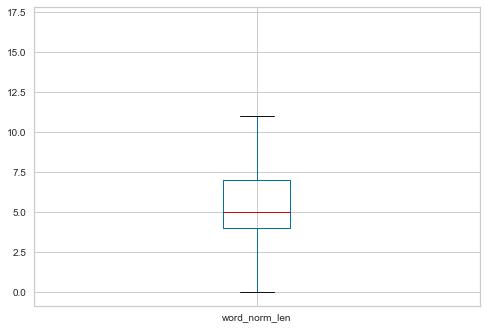

In [389]:
# Distribution of word length (after normalization and cleaning)

words_corpus_df_clean_2.word_norm_len.plot.box()

In [390]:
(words_corpus_df_clean_2.word_norm_len==0).sum(),(words_corpus_df_clean_2.word_norm_len==1).sum()

(1, 35)

In [391]:
words_corpus_df_clean_2[words_corpus_df_clean_2.word_norm_len==1].tail()

,word_norm,word,frequency,word_norm_len
31719,ن,ن,45586,1
32546,ه,ه,36480,1
32807,و,و,119914,1
38930,ى,ى,8124,1
38931,ي,ي,44263,1


In [392]:
words_corpus_df_clean_3 = words_corpus_df_clean_2.loc[words_corpus_df_clean_2.word_norm_len>1]
words_corpus_df_clean.shape,words_corpus_df_clean_2.shape,words_corpus_df_clean_3.shape

((40964, 3), (40964, 4), (40928, 4))

In [393]:
words_corpus_df_clean_3.shape[0],words_corpus_df_clean_3.word_norm.nunique()

(40928, 40928)

In [394]:
assert(words_corpus_df_clean_3.shape[0]==words_corpus_df_clean_3.word_norm.nunique())

### Remove very long words

In [395]:
words_corpus_df_clean_3.word_norm_len.describe()

count    40928.000000
mean         5.584685
std          1.597932
min          2.000000
25%          4.000000
50%          5.000000
75%          7.000000
max         17.000000
Name: word_norm_len, dtype: float64

In [396]:
(words_corpus_df_clean_3.word_norm_len>=15).sum(),(words_corpus_df_clean_3.word_norm_len>=20).sum()

(1, 0)

In [397]:
words_corpus_df_clean_3.sort_values(by='word_norm_len',ascending=False).head(40)

,word_norm,word,frequency,word_norm_len
5657,التربيةالاجتماعية,التربيةالاجتماعية,226,17
27953,للبتروكيماويات,للبتروكيماويات,49,14
5104,البتروكيماويات,البتروكيماويات,118,14
5058,الباربيتيورات,الباربيتيورات,56,13
5057,الباراسيتامول,الباراسيتامول,37,13
5193,البروتستانتية,البروتستانتية,39,13
4334,الإمبراطوريات,الإمبراطوريات,36,13
4627,الاستراتيجيات,الاستراتيجيات,58,13
5105,البتروكيماوية,البتروكيماوية,156,13
33858,والاستراتيجية,والاستراتيجية,38,13


*Remark*: most words with 15 or more characters (shown above) are actually multi-word expressions with missing spaces.

In [398]:
words_corpus_df_clean_4 = words_corpus_df_clean_3.loc[words_corpus_df_clean_3.word_norm_len<15]
words_corpus_df_clean.shape,words_corpus_df_clean_2.shape,words_corpus_df_clean_3.shape,words_corpus_df_clean_4.shape

((40964, 3), (40964, 4), (40928, 4), (40927, 4))

In [400]:
assert(words_corpus_df_clean_4.shape[0]==words_corpus_df_clean_4.word_norm.nunique())

In [401]:
words_corpus_df_clean_4.head()

,word_norm,word,frequency,word_norm_len
2,آئ,آئ,33,2
3,آب,آب,466,2
4,آباء,آباء,58,4
5,آبائه,آبائه,30,5
6,آبائهم,آبائهم,131,6


In [440]:
words_corpus_df_clean_4.shape

(40927, 4)

In [439]:
words_corpus_df_clean_4.sort_values(by='frequency',ascending=True).head(10)

,word_norm,word,frequency,word_norm_len
18207,تلاشت,تلاشت,30,5
35889,وتجن,وتجن,30,4
16622,تتناقض,تتناقض,30,6
16624,تتنوع,تتنوع,30,5
35895,وتحتل,وتحتل,30,5
19065,جزائريين,جزائريين,30,8
22622,شعائرهم,شعائرهم,30,7
32541,نيودلهي,نيودلهي,30,7
24436,عياذا,عياذا,30,5
5972,التكتيك,التكتيك,30,7


In [441]:
## Store word list in a file

filename = '../../generated_data/OSAC_words.csv'
my_list = words_corpus_df_clean_4.word_norm.tolist()
assert(len(my_list)==len(set(my_list)))

with open(filename, "w", encoding='utf8') as textfile:
    for w in my_list:
        textfile.write(str(w) + ",MSA" + "\n")

***

In [445]:
## Just checking ...

L = ['الحبس','ياريت','يزي','يطيح','باش','بالقوي','بابا','ايه','وش'
     ,'انتي','وهوما','يجي','وه','يكونو','انو','ايا','ياسي','ياسر','وياسر','ولات','الحجامة', 'الخمج','الجاية', 'اكا']
idx = words_corpus_df_clean_4.word_norm.isin(L)
words_corpus_df_clean_4[idx]

,word_norm,word,frequency,word_norm_len
6623,الحبس,الحبس,104,5
6640,الحجامة,الحجامة,276,7
13565,ايه,ايه,77,3
13764,بابا,بابا,420,4
37083,وش,وش,133,2
38418,وه,وه,862,2
38548,وياسر,وياسر,31,5
39011,ياسر,ياسر,350,4
